# ONLY OvR !

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [27]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

## Small-scale experiments

### Initialize

#### Variables

In [28]:
SCALE = 'SmallScale'
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = 10

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [29]:
ARCHITECTURE = 'LeNet'   
sm_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [30]:
ARCHITECTURE = 'LeNet'          
eos_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg 40k)'},
]

#### Evaluation data from OvR

In [31]:
ARCHITECTURE = 'LeNet'   
ovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [32]:
ARCHITECTURE = 'LeNet'          
ovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OvR'], 'label': 'OvR-F (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OvR'], 'label': 'OvR-H (0)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H (0.4)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OvR'], 'label': 'OvR-H (0.8)'}],
}

In [33]:
ARCHITECTURE = 'LeNet'
ovr_data_info_3_T_10k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OvR'], 'label': 'OvR (w/ neg 10k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 10k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 10k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 10k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 10k)'}],
}
ovr_data_info_3_T_20k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OvR'], 'label': 'OvR (w/ neg 20k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 20k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 20k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 20k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 20k)'}],
}
ovr_data_info_3_T_30k = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OvR'], 'label': 'OvR (w/ neg 30k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OvR'], 'label': 'OvR-C (b w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_g', 'OvR'], 'label': 'OvR-C (g w/ neg 30k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 30k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 30k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 30k)'}],
}
ovr_data_info_3_T = {
    'base':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg 40k)'}],
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg 40k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 40k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 40k)'}],
}

### 0. Tuning

#### Loss weighting parameter - neg 0
- Best C OvR : global 
- Best F OvR : 2
- Best M OvR : 0.4

In [34]:
# Class balancing - batch/global
data_info = ovr_data_info_2_T['C']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0035	0.1152	0.1083	0.0050	0.8624	0.8224	0.8641
0.0025	0.1119	0.1033	0.0051	0.8697	0.8187	0.8711


In [35]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_2_T['F']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0011	0.0815	0.0672	0.0091	0.8843	0.8437	0.8797
0.0013	0.0814	0.0735	0.0088	0.8478	0.8036	0.8470
0.0010	0.0827	0.0689	0.0076	0.8877	0.8301	0.8853
0.0006	0.0809	0.0638	0.0079	0.8892	0.8357	0.8909
0.0008	0.0790	0.0646	0.0085	0.8914	0.8345	0.8907


In [36]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_2_T['M']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0009	0.0783	0.0661	0.0104	0.8663	0.8224	0.8686
0.0016	0.0866	0.0810	0.0080	0.8676	0.8207	0.8674
0.0024	0.1046	0.0939	0.0062	0.8785	0.8156	0.8775
0.0024	0.1075	0.0947	0.0063	0.8498	0.7685	0.8523
0.0022	0.1057	0.1033	0.0054	0.8528	0.8121	0.8539


#### Loss weighting parameter - neg All
- Best C OvR : batch 
- Best F OvR : 1
- Best M OvR : 0.2

In [37]:
# Class balancing - batch/global
data_info = ovr_data_info_3_T['C']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0012	0.0397	0.0024	0.0177	0.9801	0.8605	0.9789
0.0011	0.0399	0.0024	0.0192	0.9785	0.8576	0.9786


In [38]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_3_T['F']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0009	0.0360	0.0017	0.0243	0.9791	0.8582	0.9784
0.0009	0.0372	0.0021	0.0217	0.9785	0.8597	0.9783
0.0007	0.0351	0.0016	0.0284	0.9786	0.8544	0.9785
0.0007	0.0344	0.0013	0.0312	0.9784	0.8568	0.9772
0.0007	0.0358	0.0017	0.0265	0.9789	0.8609	0.9776


In [39]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_3_T['M']
results = evals.print_metrics(data_info, show_osa_v=True)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑	maxOSA_V↑
0.0008	0.0387	0.0016	0.0238	0.9798	0.8498	0.9785
0.0008	0.0363	0.0016	0.0250	0.9788	0.8511	0.9793
0.0008	0.0380	0.0018	0.0243	0.9782	0.8529	0.9789
0.0011	0.0389	0.0025	0.0193	0.9782	0.8555	0.9791
0.0010	0.0395	0.0022	0.0194	0.9792	0.8601	0.9785


### Metrics Plots


In [40]:
base_data_info = []
base_data_info.append(sm_data_info_1[0])
base_data_info.append(eos_data_info_3[-1])

for idx in range(len(base_data_info)):
    print(base_data_info[idx]['info'])

base_results = evals.print_metrics(base_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


In [41]:
ovr_data_info = []
ovr_data_info.append(ovr_data_info_1[0])
ovr_data_info.append(ovr_data_info_3_T_10k['base'][0])
ovr_data_info.append(ovr_data_info_3_T_20k['base'][0])
ovr_data_info.append(ovr_data_info_3_T_30k['base'][0])
ovr_data_info.append(ovr_data_info_3_T['base'][0])

for idx in range(len(ovr_data_info)):
    print(ovr_data_info[idx]['info'])

ovr_results = evals.print_metrics(ovr_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


In [42]:
c_data_info = []
c_data_info.append(ovr_data_info_2_T['C'][1])
c_data_info.append(ovr_data_info_3_T_10k['C'][0])
c_data_info.append(ovr_data_info_3_T_20k['C'][0])
c_data_info.append(ovr_data_info_3_T_30k['C'][0])
c_data_info.append(ovr_data_info_3_T['C'][0])

for idx in range(len(c_data_info)):
    print(c_data_info[idx]['info'])

c_results = evals.print_metrics(c_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


In [43]:
f_data_info = []
f_data_info.append(ovr_data_info_2_T['F'][3])
f_data_info.append(ovr_data_info_3_T_10k['F'][2])
f_data_info.append(ovr_data_info_3_T_20k['F'][2])
f_data_info.append(ovr_data_info_3_T_30k['F'][2])
f_data_info.append(ovr_data_info_3_T['F'][2])

for idx in range(len(f_data_info)):
    print(f_data_info[idx]['info'])

f_results = evals.print_metrics(f_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


In [44]:
h_data_info = []
h_data_info.append(ovr_data_info_2_T['M'][2])
h_data_info.append(ovr_data_info_3_T_10k['M'][1])
h_data_info.append(ovr_data_info_3_T_20k['M'][1])
h_data_info.append(ovr_data_info_3_T_30k['M'][1])
h_data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(h_data_info)):
    print(h_data_info[idx]['info'])

h_results = evals.print_metrics(h_data_info, is_verbose=False)

['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


Text(0.5, 1.0, 'Non-Target')

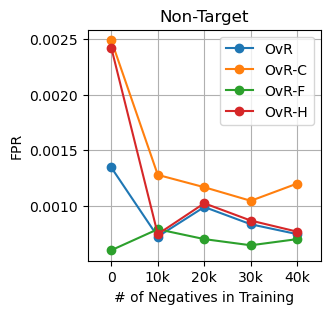

In [45]:
ovr_fpr_nt = [item['fpr_nt_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_nt_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_nt_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_nt_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('FPR')
plt.grid('both')
plt.title('Non-Target')

Text(0.5, 1.0, 'Unknown')

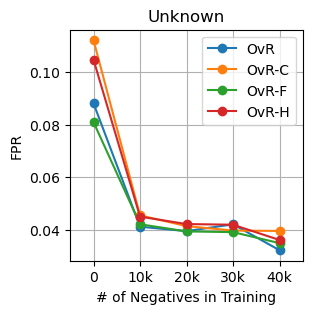

In [46]:
ovr_fpr_nt = [item['fpr_u_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_u_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_u_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_u_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('FPR')
plt.grid('both')
plt.title('Unknown')

Text(0.5, 1.0, 'Negative')

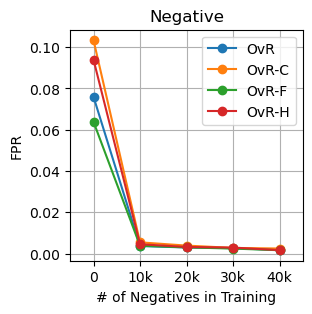

In [47]:
ovr_fpr_nt = [item['fpr_n_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fpr_n_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fpr_n_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fpr_n_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('FPR')
plt.grid('both')
plt.title('Negative')

Text(0.5, 1.0, 'Target')

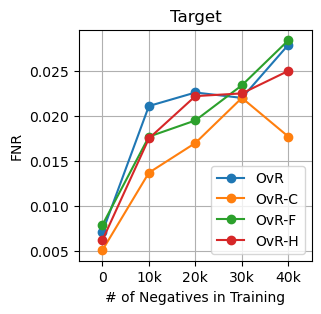

In [48]:
ovr_fpr_nt = [item['fnr_avg'] for item in ovr_results['res_fpr_fnr']]
c_fpr_nt = [item['fnr_avg'] for item in c_results['res_fpr_fnr']]
f_fpr_nt = [item['fnr_avg'] for item in f_results['res_fpr_fnr']]
h_fpr_nt = [item['fnr_avg'] for item in h_results['res_fpr_fnr']]

plt.figure(figsize=(3,3))

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('FNR')
plt.grid('both')
plt.title('Target')

Text(0.5, 1.0, 'Test Set: Known + Negative')

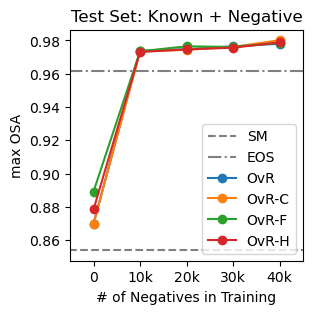

In [49]:
ovr_fpr_nt = [item['iosa_neg'] for item in ovr_results['oosa']]
c_fpr_nt = [item['iosa_neg'] for item in c_results['oosa']]
f_fpr_nt = [item['iosa_neg'] for item in f_results['oosa']]
h_fpr_nt = [item['iosa_neg'] for item in h_results['oosa']]

plt.figure(figsize=(3,3))

# Baseline
base_fpr_nt = [item['iosa_neg'] for item in base_results['oosa']]

plt.hlines(base_fpr_nt[0], xmin=-1, xmax=5, label='SM', linestyles='--', color='grey')
plt.hlines(base_fpr_nt[1], xmin=-1, xmax=5, label='EOS', linestyles='-.', color='grey')

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('max OSA')
plt.title('Test Set: Known + Negative')

Text(0.5, 1.0, 'Test Set: Known + Unknown')

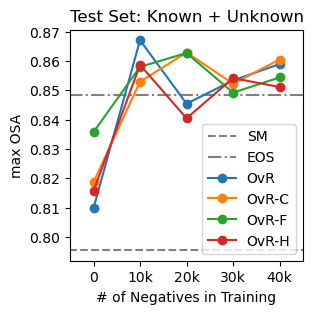

In [50]:
ovr_fpr_nt = [item['iosa_unkn'] for item in ovr_results['oosa']]
c_fpr_nt = [item['iosa_unkn'] for item in c_results['oosa']]
f_fpr_nt = [item['iosa_unkn'] for item in f_results['oosa']]
h_fpr_nt = [item['iosa_unkn'] for item in h_results['oosa']]

plt.figure(figsize=(3,3))

# Baseline
base_fpr_nt = [item['iosa_unkn'] for item in base_results['oosa']]

plt.hlines(base_fpr_nt[0], xmin=-1, xmax=5, label='SM', linestyles='--', color='grey')
plt.hlines(base_fpr_nt[1], xmin=-1, xmax=5, label='EOS', linestyles='-.', color='grey')

plt.plot(ovr_fpr_nt, label='OvR', marker='o')
plt.plot(c_fpr_nt, label='OvR-C', marker='o')
plt.plot(f_fpr_nt, label='OvR-F', marker='o')
plt.plot(h_fpr_nt, label='OvR-H', marker='o')

plt.legend()
plt.xlim((-0.5,4.5))
plt.xticks(range(len(ovr_fpr_nt)), ['0','10k','20k','30k','40k'])
plt.xlabel('# of Negatives in Training')
plt.ylabel('max OSA')
plt.title('Test Set: Known + Unknown')

### OSA Plots


In [56]:
no_neg_data_info = []
no_neg_data_info.append(sm_data_info_1[0])
no_neg_data_info.append(ovr_data_info_1[0])
no_neg_data_info.append(ovr_data_info_2_T['C'][1])
no_neg_data_info.append(ovr_data_info_2_T['F'][3])
no_neg_data_info.append(ovr_data_info_2_T['M'][2])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

no_neg_results = evals.print_metrics(no_neg_data_info, is_verbose=False)

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


In [57]:
neg_data_info = []
neg_data_info.append(eos_data_info_3[-1])
neg_data_info.append(ovr_data_info_3_T['base'][0])
neg_data_info.append(ovr_data_info_3_T['C'][0])
neg_data_info.append(ovr_data_info_3_T['F'][2])
neg_data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

neg_results = evals.print_metrics(neg_data_info, is_verbose=False)

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']
FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑


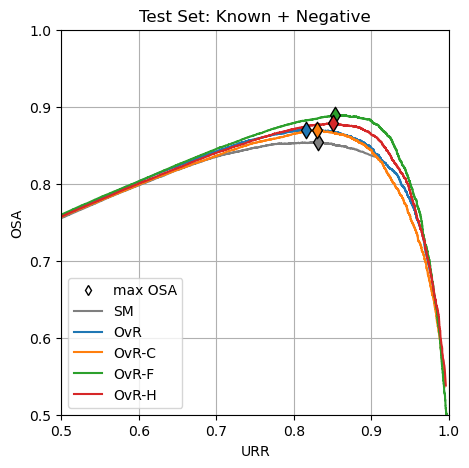

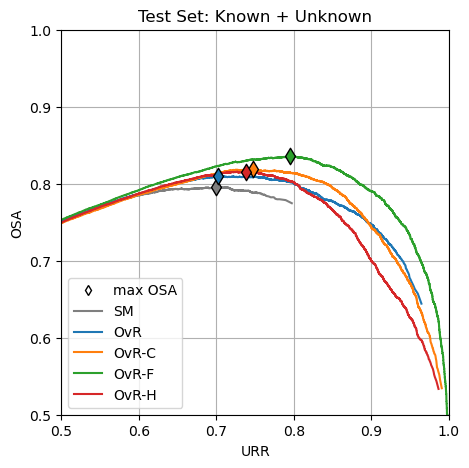

In [58]:
labels = ['SM', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(no_neg_data_info)-1]
evals.plot_OSA(no_neg_data_info, colors, labels = labels, figsize = (5,5), lim=((0.5,1),(0.5,1)),
               show_point=(False, True))

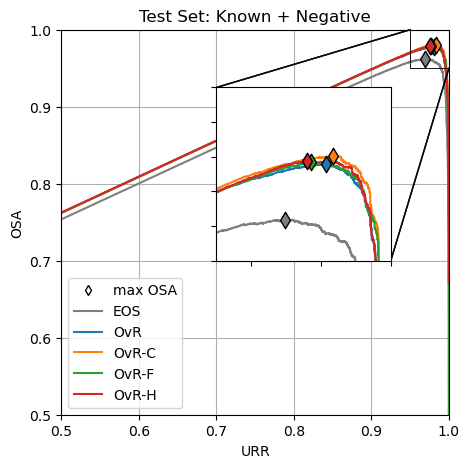

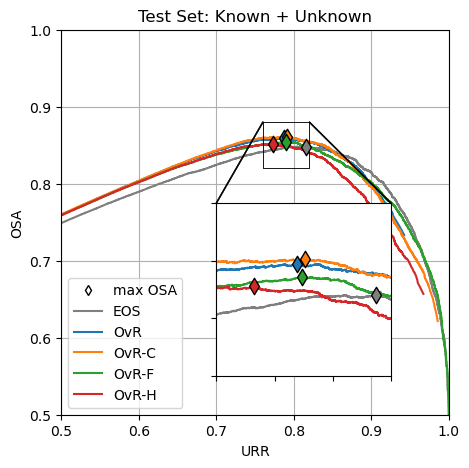

In [59]:
labels = ['EOS', 'OvR', 'OvR-C', 'OvR-F', 'OvR-H']
colors = [CMAP_t10[-3]] + CMAP_t10[0:len(neg_data_info)-1]
evals.plot_OSA(neg_data_info, colors, labels=labels, figsize = (5,5), lim=((0.5,1),(0.5,1)),
               show_point=(False, True),
               zoom=((True, (0.95,1.0,0.95,1.0),(0.4,0.4,0.45,0.45)), 
                     (True, (0.76,0.82,0.82,0.88),(0.4,0.1,0.45,0.45))))

### RQ 1 and 2

In [11]:
data_info = []
data_info.append(sm_data_info_1[0])
data_info.append(ovr_data_info_1[0])
data_info.append(ovr_data_info_2_T['C'][1])
data_info.append(ovr_data_info_2_T['F'][3])
data_info.append(ovr_data_info_2_T['M'][2])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_2', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OvR']


In [12]:
results_1 = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0008	0.0996	0.0997	0.0069	0.8540	0.7954
0.0013	0.0880	0.0759	0.0071	0.8700	0.8098
0.0025	0.1119	0.1033	0.0051	0.8697	0.8187
0.0006	0.0809	0.0638	0.0079	0.8892	0.8357
0.0024	0.1046	0.0939	0.0062	0.8785	0.8156


In [ ]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

### RQ 3 and 4

#### 10k

In [15]:
data_info = []
data_info.append(ovr_data_info_3_T_10k['base'][0])
data_info.append(ovr_data_info_3_T_10k['C'][0])
data_info.append(ovr_data_info_3_T_10k['F'][2])
data_info.append(ovr_data_info_3_T_10k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']


In [16]:
results_1 = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0007	0.0413	0.0036	0.0211	0.9738	0.8671
0.0013	0.0456	0.0054	0.0137	0.9734	0.8529
0.0008	0.0422	0.0038	0.0177	0.9735	0.8580
0.0007	0.0451	0.0045	0.0175	0.9730	0.8587


#### 20k

In [17]:
data_info = []
data_info.append(ovr_data_info_3_T_20k['base'][0])
data_info.append(ovr_data_info_3_T_20k['C'][0])
data_info.append(ovr_data_info_3_T_20k['F'][2])
data_info.append(ovr_data_info_3_T_20k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']


In [18]:
results_1 = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0010	0.0396	0.0029	0.0226	0.9747	0.8454
0.0012	0.0415	0.0038	0.0170	0.9744	0.8629
0.0007	0.0395	0.0030	0.0195	0.9764	0.8627
0.0010	0.0423	0.0032	0.0222	0.9746	0.8404


#### 30k

In [19]:
data_info = []
data_info.append(ovr_data_info_3_T_30k['base'][0])
data_info.append(ovr_data_info_3_T_30k['C'][0])
data_info.append(ovr_data_info_3_T_30k['F'][2])
data_info.append(ovr_data_info_3_T_30k['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']


In [20]:
results_1 = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0008	0.0422	0.0026	0.0220	0.9764	0.8534
0.0010	0.0399	0.0027	0.0220	0.9761	0.8522
0.0006	0.0393	0.0024	0.0234	0.9761	0.8492
0.0009	0.0421	0.0029	0.0225	0.9756	0.8541


#### 40k (All)

In [24]:
data_info = []
data_info.append(eos_data_info_3[-1])
data_info.append(ovr_data_info_3_T['base'][0])
data_info.append(ovr_data_info_3_T['C'][0])
data_info.append(ovr_data_info_3_T['F'][2])
data_info.append(ovr_data_info_3_T['M'][1])

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_1', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


In [25]:
results_1 = evals.print_metrics(data_info)

FPR(NT)↓	FPR(U)↓	FPR(N)↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0014	0.0417	0.0038	0.0405	0.9619	0.8483
0.0007	0.0324	0.0017	0.0279	0.9780	0.8589
0.0012	0.0397	0.0024	0.0177	0.9801	0.8605
0.0007	0.0351	0.0016	0.0284	0.9786	0.8544
0.0008	0.0363	0.0016	0.0250	0.9788	0.8511


#### Legend

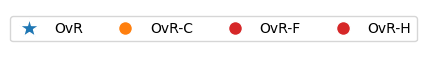

In [299]:
# Composing separate legend plot
labels = ['OvR', 'OvR-C', 'OvR-F', 'OvR-H']
legend_elements = [
    Line2D([0], [0], markerfacecolor=CMAP_t10[0], color='w',marker='*', markersize=15),
    Line2D([0], [0], markerfacecolor=CMAP_t10[1], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, labels = labels, loc='center', ncol=4, 
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.axes.axis("off")
plt.show()